# Spatio Temporal Grid Notebook

In [15]:
import numpy
import pandas
import matplotlib.pyplot as plt
import datetime as dt

# readjust padding
import matplotlib as mpl
mpl.rcParams['savefig.pad_inches'] = 0.2
import seaborn as sns

from image_generator import plot_sky, show_training_grid, get_waypoints, create_times_array, create_voyage


# Voyage Waypoints

Our pretend voyage won't be very long. We'll plan to travel from 39 N , 140 W to 37 N, 138 W. A distance of 152.77 nautical miles by great circle. 

Number of unique waypoints:  11


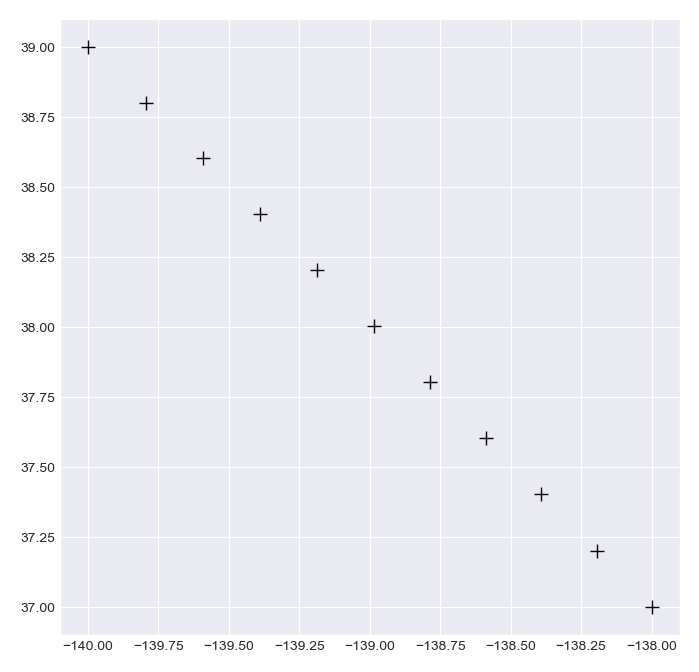

In [19]:
# define starting and ending positions
start = (39, -140)
end = (37, -138)

# get waypoints
waypoints = get_waypoints(start, end, 10, list_of_mile_displacements=[0])

# use seaborn darkgrid
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,8))
# use '+' symbol for waypoints
ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')

In [ ]:
# create a voyage
voyage = create_voyage(

# Training Grid

We begin by constructing a grid, layered in both space and time that surrounds our intended voyage.

In [23]:
def show_training_grid(start, end, points_along_track=100, displacements=10, displacement_interval=1):

    # get waypoints
    flat_track = get_waypoints(start, end, points_along_track, [x for x in range(0,displacements,displacement_interval)])
     
    # plot points in flat_track
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(flat_track[:, 1], flat_track[:, 0], s=1, c='red')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Training Grid')

    ax.plot(waypoints[:,1], waypoints[:,0], 'k+', markersize=10, label='Waypoints')

    plt.tight_layout()

    # make backround blue
    # ax.set_facecolor('xkcd:light blue')

    # show plot
    plt.show()

Number of unique waypoints:  1919


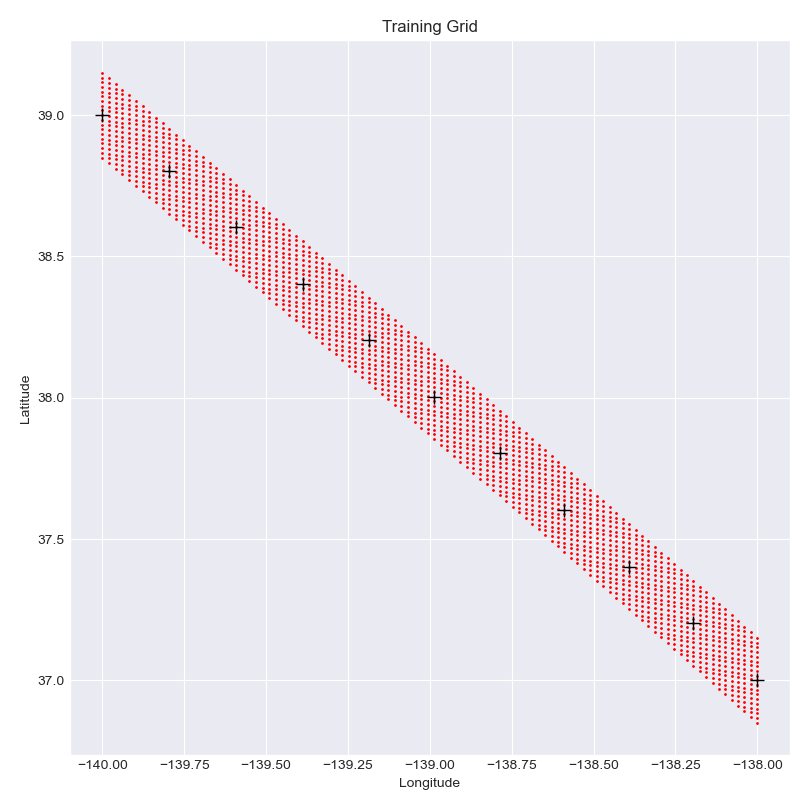

In [24]:

# show training grid
show_training_grid(start=start, end=end, points_along_track=100, displacements=10, displacement_interval=1)